# Tesing multi group permutation

In the case of dependencies between observations during a 2 sample test, we hold fixed their relative labels during the permutation. 

Here, we simulate pairs of observations more similar to one another than others. We form two sets of labels in the two sample test. In the "null" case, we are pair agnostic. Otherwise, either the pairs are assigned:
- the same label (differences **across**)
- different labels (differences **within**)

Followng the simulations, the scipy permutation code is validated and we see that the permutations sort pairs correctly while the "null" permutation case shows no pattern.

In [1]:
import sys, os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend import Legend
%matplotlib inline

sys.path.append(os.path.realpath('..'))
from hyppo.independence import Dcorr
from scipy.spatial.distance import squareform, pdist
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [91]:
n = 40
d = 4
n_datasets = 500

# i.e. Experts rest vs. experts compassion
m = 2
datasets_within_11 = []
for i in range(n_datasets):
    np.random.seed(i)
    mus = np.random.normal(0,1,(n,d))
    X = np.vstack(
        [np.random.normal(mu,0.1,(m,d)) for mu in mus]
    )
    datasets_within_11.append(X)
Y_within_11 = np.hstack([[0,1] for _ in range(n)])
groups_within_11 = np.hstack(
    [[f'{i}']*m for i in range(n)]
)

# i.e. Experts rest vs. experts meditating
datasets_within_12 = []
m = 3
for i in range(n_datasets):
    np.random.seed(i)
    mus = np.random.normal(0,1,(n,d))
    X = np.vstack(
        [np.random.normal(mu,0.1,(m,d)) for mu in mus]
    )
    datasets_within_12.append(X)
Y_within_12 = np.hstack([[0,1,1] for _ in range(n)])
groups_within_12 = np.hstack(
    [[f'{i}']*(m) for i in range(n)]
)

# i.e. Novices meditating vs. experts meditating
datasets_across_22 = []
m = 2
for i in range(n_datasets):
    np.random.seed(i)
    mus = np.random.normal(0,1,(n,d))
    X = np.vstack(
        [np.random.normal(mu,0.1,(m,d)) for mu in mus]
    )
    datasets_across_22.append(X)
Y_across_22 = np.hstack(
    [[0] for _ in range(int(n/2)*m)] +
    [[1] for _ in range(int(n/2)*m)]
)
groups_across_22 = np.hstack(
    [[f'{i}']*(m) for i in range(n)]
)

# i.e. Novices all vs. experts all
datasets_across_33 = []
m = 3
for i in range(n_datasets):
    np.random.seed(i)
    mus = np.random.normal(0,1,(n,d))
    X = np.vstack(
        [np.random.normal(mu,0.1,(m,d)) for mu in mus]
    )
    datasets_across_33.append(X)
Y_across_33 = np.hstack(
    [[0] for _ in range(int(n/2)*m)] +
    [[1] for _ in range(int(n/2)*m)]
)
groups_across_33 = np.hstack(
    [[f'{i}']*(m) for i in range(n)]
)

# i.e. Novices resting vs. Experts meditating
datasets_across_12 = []
m = 2
for i in range(n_datasets):
    np.random.seed(i)
    mus = np.random.normal(0,1,(n,d))
    X = np.vstack(
        [np.vstack(
            [np.random.normal(0,1,(1,d))]*2 + 
            [np.random.normal(mu,0.1,(m,d))]
        ) for mu in mus]
    )
    datasets_across_12.append(X)
Y_across_12 = np.hstack([[0,0,1,1] for _ in range(n)])
groups_across_12 = np.hstack(
    [[f'{i}']*m + [f'{i+n}']*(m) for i in range(n)]
)

In [92]:
test_list = [
    #('Experts rest vs. experts compassion', datasets_within_11, Y_within_11, groups_within_11, 'within'),
    #('Experts rest vs. experts meditating', datasets_within_12, Y_within_12, groups_within_12, 'within'),
    #('Novices meditating vs. experts meditating', datasets_across_22, Y_across_22, groups_across_22, 'across'),
    #('Novices all vs. experts all', datasets_across_33, Y_across_33, groups_across_33, 'across'),
    ('Novices resting vs. Experts meditating', datasets_across_12, Y_across_12, groups_across_12, 'across')
]
test_list_pvalues = test_list_pvalues[:4]

In [93]:
for example, datasets, Y, groups, perm_struct in test_list:
    pvalues = []
    for X in datasets:
        stat, pval = Dcorr().test(
            X,Y,
            reps=100,
            workers=-1,
            auto=False,
            permute_groups=groups,
            permute_structure=perm_struct,
        )
        pvalues.append(pval)
    test_list_pvalues.append(pvalues)

In [94]:
test_list = [
    ('Experts rest vs. experts compassion', datasets_within_11, Y_within_11, groups_within_11, 'within'),
    ('Experts rest vs. experts meditating', datasets_within_12, Y_within_12, groups_within_12, 'within'),
    ('Novices meditating vs. experts meditating', datasets_across_22, Y_across_22, groups_across_22, 'across'),
    ('Novices all vs. experts all', datasets_across_33, Y_across_33, groups_across_33, 'across'),
    ('Novices resting vs. Experts meditating', datasets_across_12, Y_across_12, groups_across_12, 'across')
]

Text(0.5, 0.93, 'Distribution of pvalues under restricted permutations')

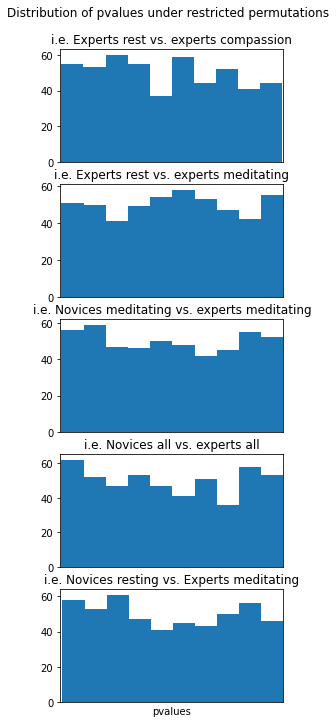

In [95]:
fig,axes = plt.subplots(5,1,sharex=True,figsize=(4,12))
for ax,test,pvals in zip(axes, test_list, test_list_pvalues):
    ax.hist(pvals)
    ax.set_title(f'i.e. {test[0]}')
    ax.set_xlim(0,1)
for ax in axes[:-1]:
    ax.set_xticks([])
axes[-1].set_xlabel('pvalues')
fig.suptitle('Distribution of pvalues under restricted permutations', y=0.93)

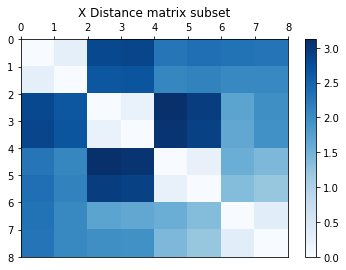

In [3]:
data = squareform(pdist(datasets[0][:8]))
fig, ax = plt.subplots()
heatmap = ax.pcolor(data, cmap=plt.cm.Blues)
plt.colorbar(heatmap)
# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()
plt.title('X Distance matrix subset')
plt.show()

### Across classes

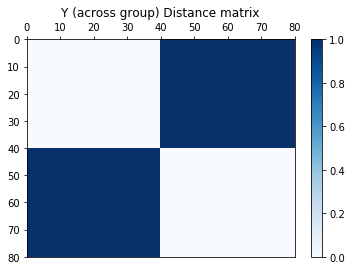

In [4]:
data = squareform(pdist(Y_across[:,None]))
fig, ax = plt.subplots()
heatmap = ax.pcolor(data, cmap=plt.cm.Blues)
plt.colorbar(heatmap)
# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()
plt.title('Y (across group) Distance matrix')
plt.show()

In [5]:
pvalues_across_uc = []
for X in datasets:
    stat_uc, pval_uc = Dcorr().test(
        X,Y_across,
        reps=100,
        workers=-1,
        auto=False,
        permute_groups=np.arange(Y_across.shape[0]),
        permute_structure='full'
    )
    pvalues_across_uc.append(pval_uc)

Text(0, 0.5, 'n')

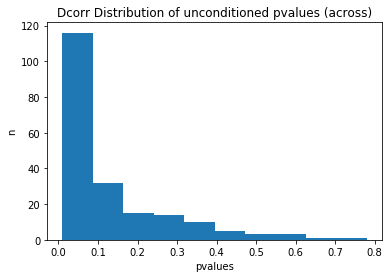

In [6]:
plt.hist(pvalues_across_uc)
plt.title('Dcorr Distribution of unconditioned pvalues (across)')
plt.xlabel('pvalues')
plt.ylabel('n')

In [14]:
pvalues_across_c = []
for X in datasets:
    stat_c, pval_c = Dcorr().test(
        X,Y_across,
        reps=100,
        workers=-1,
        auto=False,
        permute_groups=groups,
        permute_structure='across'
    )
    pvalues_across_c.append(pval_c)

Text(0, 0.5, 'n')

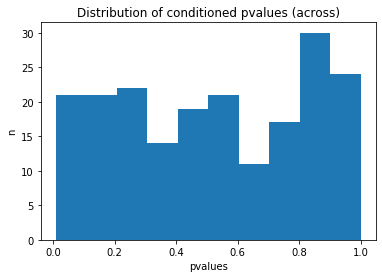

In [15]:
plt.hist(pvalues_across_c)
plt.title('Distribution of conditioned pvalues (across)')
plt.xlabel('pvalues')
plt.ylabel('n')

### Within class

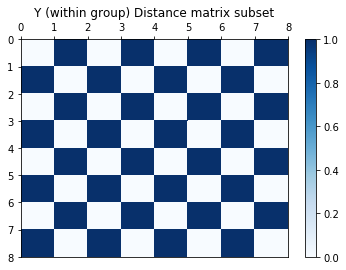

In [9]:
data = squareform(pdist(Y_within[:8,None]))
fig, ax = plt.subplots()
heatmap = ax.pcolor(data, cmap=plt.cm.Blues)
plt.colorbar(heatmap)
# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()
plt.title('Y (within group) Distance matrix subset')
plt.show()

In [10]:
pvalues_within_uc = []
for X in datasets:
    stat_uc, pval_uc = Dcorr().test(
        X,Y_within,
        reps=100,
        workers=-1,
        auto=False,
        permute_groups=np.arange(Y_across.shape[0]),
        permute_structure='full'
    )
    pvalues_within_uc.append(pval_uc)

Text(0, 0.5, 'n')

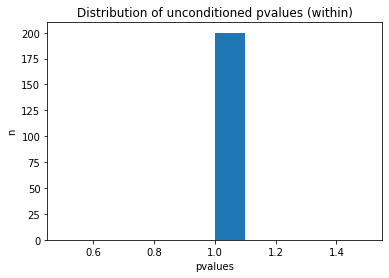

In [11]:
plt.hist(pvalues_within_uc)
plt.title('Distribution of unconditioned pvalues (within)')
plt.xlabel('pvalues')
plt.ylabel('n')

In [34]:
pvalues_within_c = []
for X in datasets:
    stat_c, pval_c = Dcorr().test(
        X,Y_within,
        reps=100,
        workers=-1,
        auto=False,
        permute_groups=groups,
        permute_structure='within'
    )
    pvalues_within_c.append(pval_c)

Text(0, 0.5, 'n')

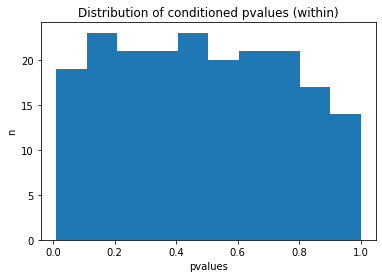

In [35]:
plt.hist(pvalues_within_c)
plt.title('Distribution of conditioned pvalues (within)')
plt.xlabel('pvalues')
plt.ylabel('n')

In [17]:
from collections import defaultdict
from copy import deepcopy

# permutation group shuffling class
class _PermGroups(object):
    """
    Helper function to calculate parallel p-value.
    """
    def __init__(self, y, permute_groups=None, permute_structure=None):
        self.permute_groups = permute_groups
        self.permute_structure = permute_structure
        self.y_labels = np.unique(y, return_inverse=True, axis=1)[1]
        if permute_structure == 'within':
            self.group_indices = defaultdict(list)
            for i,group in enumerate(permute_groups):
                self.group_indices[group].append(i)
        elif permute_structure == 'across':
            # dict: [y_label] -> list(indices)
            self.class_indices = defaultdict(list) 
            group_indices = defaultdict(list)
            for i,(group,label) in enumerate(zip(permute_groups, self.y_labels)):
                self.class_indices[label].append(i)
                group_indices[group].append(i)
            # list of group indices, sorted descending order
            self.group_indices = sorted(
                group_indices.values(), key=lambda x: len(x), reverse=True
            )

    def __call__(self):
        if self.permute_groups is None or self.permute_structure=='full':
            order = np.random.permutation(self.y_labels.shape[0])
        elif self.permute_structure == 'within':
            old_indices = np.hstack(self.group_indices.values())
            new_indices = np.hstack([np.random.permutation(idx) for idx in self.group_indices.values()])
            order = np.ones(self.y_labels.shape[0]) * -1
            order[np.asarray(old_indices)] = new_indices
            order = order.astype(int)
        elif self.permute_structure == 'across':
            # Copy dict: [y_label] -> list(indices)
            class_indices_copy = deepcopy(self.class_indices)
            new_indices = []
            old_indices = []
            for group in self.group_indices:
                p0 = self.factorial(len(class_indices_copy[0]), len(group))
                p1 = self.factorial(len(class_indices_copy[1]), len(group))
                # New indices sampled per probabilities at that step
                if np.random.uniform() < p0 / (p0+p1):
                    new_indices += [class_indices_copy[0].pop() for _ in range(len(group))]
                else:
                    new_indices += [class_indices_copy[1].pop() for _ in range(len(group))]
                # Old indices in correct order
                old_indices += group
            order = np.ones(self.y_labels.shape[0]) * -1
            order[np.asarray(old_indices)] = new_indices
            order = order.astype(int)
        else:
            msg = "permute_structure must be of {'full', 'within', 'across'}"
            raise ValueError(msg)

        return order

In [27]:
pg = _PermGroups(squareform(pdist(Y_within[:,None])), groups, 'within')

In [28]:
pg()

array([ 0,  1,  3,  2,  5,  4,  7,  6,  8,  9, 11, 10, 12, 13, 15, 14, 17,
       16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 26, 28, 29, 31, 30, 33, 32,
       35, 34, 37, 36, 39, 38, 41, 40, 42, 43, 44, 45, 46, 47, 49, 48, 50,
       51, 52, 53, 55, 54, 57, 56, 59, 58, 61, 60, 63, 62, 65, 64, 67, 66,
       68, 69, 71, 70, 73, 72, 75, 74, 77, 76, 79, 78])

In [29]:
pg()

array([ 1,  0,  3,  2,  5,  4,  6,  7,  9,  8, 11, 10, 13, 12, 15, 14, 16,
       17, 18, 19, 21, 20, 22, 23, 24, 25, 26, 27, 28, 29, 31, 30, 32, 33,
       34, 35, 36, 37, 39, 38, 41, 40, 43, 42, 45, 44, 46, 47, 48, 49, 51,
       50, 53, 52, 54, 55, 56, 57, 58, 59, 61, 60, 62, 63, 65, 64, 67, 66,
       69, 68, 70, 71, 72, 73, 74, 75, 76, 77, 79, 78])

## MGC vs. DCORR

In [19]:
pvalues_mgc = []
for X in datasets:
    _,pval,_ = multiscale_graphcorr(
        X,Y_across,
        reps=100,
        workers=-1,
        random_state=1,
        permute_groups=groups
    )
    pvalues_mgc.append(pval)

In [20]:
pvalues_dcorr = []
for X in datasets:
    _,pval,_ = multiscale_graphcorr(
        X,Y_across,
        reps=100,
        workers=-1,
        random_state=1,
        permute_groups=groups,
        full_scale=True
    )
    pvalues_dcorr.append(pval)

Text(0.5, 1.02, 'MGC vs. DCORR 2sample pvalue distribution (100 reps, 250 datasets)')

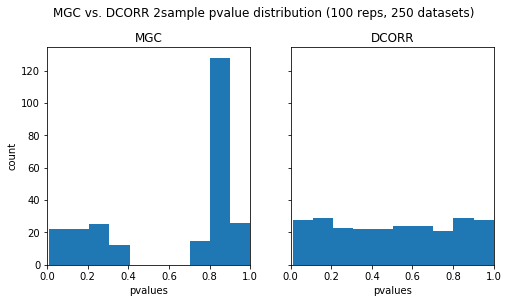

In [22]:
fig,axes = plt.subplots(1,2,sharey=True,figsize=(8,4))
axes[0].hist(pvalues_mgc)
axes[1].hist(pvalues_dcorr)
axes[0].set_ylabel('count')
axes[0].set_xlabel('pvalues')
axes[1].set_xlabel('pvalues')
axes[0].set_title('MGC')
axes[1].set_title('DCORR')
axes[0].set_xlim(0,1)
axes[1].set_xlim(0,1)
fig.suptitle('MGC vs. DCORR 2sample pvalue distribution (100 reps, 250 datasets)', y=1.02)